# 프로젝트: 인물 모드 문제점 찾기

In [13]:
import cv2
import numpy as np
import os
import tarfile
import urllib

from matplotlib import pyplot as plt
import tensorflow as tf

In [14]:
class DeepLabModel(object):
    INPUT_TENSOR_NAME = 'ImageTensor:0'
    OUTPUT_TENSOR_NAME = 'SemanticPredictions:0'
    INPUT_SIZE = 513
    FROZEN_GRAPH_NAME = 'frozen_inference_graph'

    def __init__(self, tarball_path):
        self.graph = tf.Graph()
        graph_def = None
        tar_file = tarfile.open(tarball_path)
        for tar_info in tar_file.getmembers():
            if self.FROZEN_GRAPH_NAME in os.path.basename(tar_info.name):
                file_handle = tar_file.extractfile(tar_info)
                graph_def = tf.compat.v1.GraphDef.FromString(file_handle.read())
                break
        tar_file.close()

        with self.graph.as_default():
            tf.compat.v1.import_graph_def(graph_def, name='')

        self.sess = tf.compat.v1.Session(graph=self.graph)

    def preprocess(self, img_orig):
        height, width = img_orig.shape[:2]
        resize_ratio = 1.0 * self.INPUT_SIZE / max(width, height)
        target_size = (int(resize_ratio * width), int(resize_ratio * height))
        resized_image = cv2.resize(img_orig, target_size)
        resized_rgb = cv2.cvtColor(resized_image, cv2.COLOR_BGR2RGB)
        img_input = resized_rgb
        return img_input
        
    def run(self, image):
        img_input = self.preprocess(image)
        batch_seg_map = self.sess.run(
            self.OUTPUT_TENSOR_NAME,
            feed_dict={self.INPUT_TENSOR_NAME: [img_input]})

        seg_map = batch_seg_map[0]
        return cv2.cvtColor(img_input, cv2.COLOR_RGB2BGR), seg_map

In [17]:
model_dir = os.getenv('HOME')+'/aiffel/exp8/human_segmentation/models'
download_path = os.path.join(model_dir, '/deeplab_model.tar.gz')
if not os.path.exists(download_path):
    urllib.request.urlretrieve(_DOWNLOAD_URL_PREFIX + 'deeplabv3_mnv2_pascal_train_aug_2018_01_29.tar.gz',
                   download_path)

MODEL = DeepLabModel(download_path)
print('model loaded successfully!')

model loaded successfully!


## 1. 인물사진

In [19]:
img_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/image.png'
img_orig = cv2.imread(img_path) 
print (img_orig.shape)

(1080, 1920, 3)


In [20]:
img_resized, seg_map = MODEL.run(img_orig)
print (img_orig.shape, img_resized.shape, seg_map.max())

(1080, 1920, 3) (288, 513, 3) 15


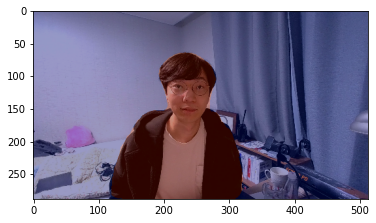

In [21]:
img_show = img_resized.copy()
seg_map = np.where(seg_map == 15, 15, 0)
img_mask = seg_map * (255/seg_map.max())
img_mask = img_mask.astype(np.uint8)
color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)
img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.35, 0.0)

plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

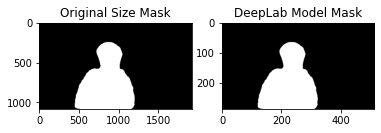

In [22]:
# 마스킹

img_mask_up = cv2.resize(img_mask, img_orig.shape[:2][::-1], interpolation=cv2.INTER_LINEAR)
_, img_mask_up = cv2.threshold(img_mask_up, 128, 255, cv2.THRESH_BINARY)

ax = plt.subplot(1,2,1)
plt.imshow(img_mask_up, cmap=plt.cm.binary_r)
ax.set_title('Original Size Mask')

ax = plt.subplot(1,2,2)
plt.imshow(img_mask, cmap=plt.cm.binary_r)
ax.set_title('DeepLab Model Mask')

plt.show()

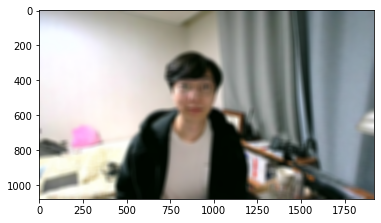

In [23]:
# 흐림 설정

img_orig_blur = cv2.blur(img_orig, (30,30))
plt.imshow(cv2.cvtColor(img_orig_blur, cv2.COLOR_BGR2RGB))
plt.show()

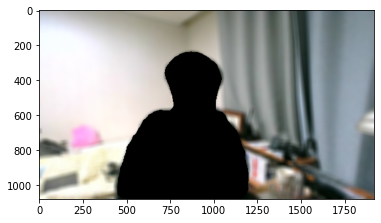

In [24]:
# 흐린 사진에서 마스크 영역 삭제

img_mask_color = cv2.cvtColor(img_mask_up, cv2.COLOR_GRAY2BGR)
img_bg_mask = cv2.bitwise_not(img_mask_color)
img_bg_blur = cv2.bitwise_and(img_orig_blur, img_bg_mask)
plt.imshow(cv2.cvtColor(img_bg_blur, cv2.COLOR_BGR2RGB))
plt.show()

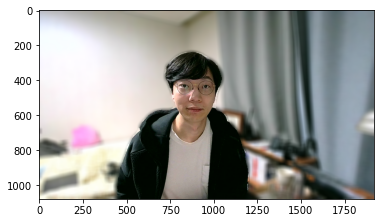

In [25]:
# 원본사진 합성

img_concat = np.where(img_mask_color==255, img_orig, img_bg_blur)
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.show()

## 2. 배경사진

In [32]:
background_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/image02.png'
background_orig = cv2.imread(background_path) 
print (background_orig.shape)

(1089, 1920, 3)


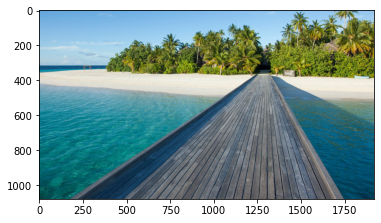

In [33]:
background_show = background_orig.copy()
background_resized = cv2.resize(background_show, img_orig.shape[:2][::-1], interpolation=cv2.INTER_LINEAR)
plt.imshow(cv2.cvtColor(background_resized, cv2.COLOR_BGR2RGB))
plt.show()

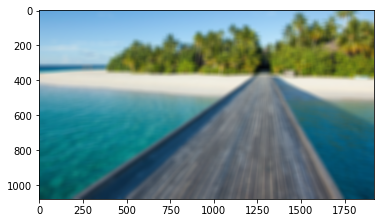

In [34]:
background_blur = cv2.blur(background_resized, (30,30))
plt.imshow(cv2.cvtColor(background_blur, cv2.COLOR_BGR2RGB))
plt.show()

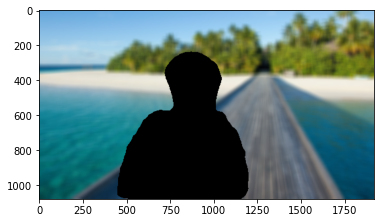

In [35]:
img_mask_color = cv2.cvtColor(img_mask_up, cv2.COLOR_GRAY2BGR)
img_bg_mask = cv2.bitwise_not(img_mask_color)
img_bg_blur = cv2.bitwise_and(background_blur, img_bg_mask)
plt.imshow(cv2.cvtColor(img_bg_blur, cv2.COLOR_BGR2RGB))
plt.show()

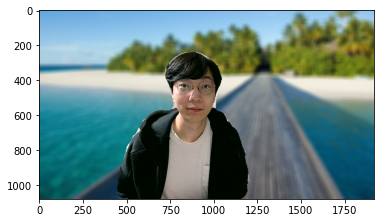

In [36]:
img_concat = np.where(img_mask_color==255, img_orig, img_bg_blur)
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.show()

## 3. 고양이 사진

In [41]:
img_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/cat.jpg'
cat_orig = cv2.imread(img_path) 
print (cat_orig.shape)

(1415, 2120, 3)


In [42]:
cat_resized, seg_map = MODEL.run(cat_orig)
print (cat_orig.shape, cat_resized.shape, seg_map.max())

(1415, 2120, 3) (342, 513, 3) 8


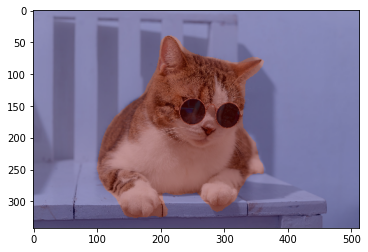

In [43]:
cat_show = cat_resized.copy()
seg_map = np.where(seg_map == 8, 8, 0)
img_mask = seg_map * (255/seg_map.max())
img_mask = img_mask.astype(np.uint8)
color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)
cat_show = cv2.addWeighted(cat_show, 0.6, color_mask, 0.35, 0.0)

plt.imshow(cv2.cvtColor(cat_show, cv2.COLOR_BGR2RGB))
plt.show()

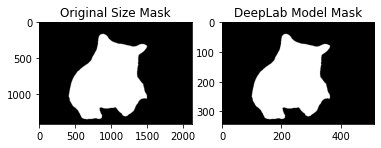

In [44]:
img_mask_up = cv2.resize(img_mask, cat_orig.shape[:2][::-1], interpolation=cv2.INTER_LINEAR)
_, img_mask_up = cv2.threshold(img_mask_up, 128, 255, cv2.THRESH_BINARY)

ax = plt.subplot(1,2,1)
plt.imshow(img_mask_up, cmap=plt.cm.binary_r)
ax.set_title('Original Size Mask')

ax = plt.subplot(1,2,2)
plt.imshow(img_mask, cmap=plt.cm.binary_r)
ax.set_title('DeepLab Model Mask')

plt.show()

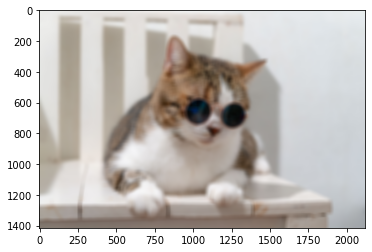

In [46]:
cat_orig_blur = cv2.blur(cat_orig, (30,30))
plt.imshow(cv2.cvtColor(cat_orig_blur, cv2.COLOR_BGR2RGB))
plt.show()

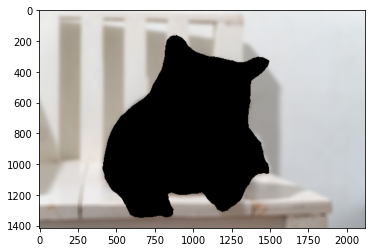

In [47]:
img_mask_color = cv2.cvtColor(img_mask_up, cv2.COLOR_GRAY2BGR)
img_bg_mask = cv2.bitwise_not(img_mask_color)
img_bg_blur = cv2.bitwise_and(cat_orig_blur, img_bg_mask)
plt.imshow(cv2.cvtColor(img_bg_blur, cv2.COLOR_BGR2RGB))
plt.show()

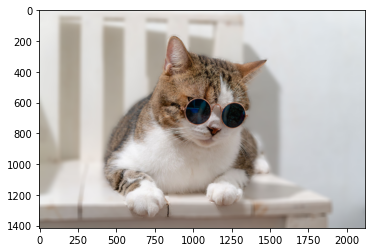

In [48]:
cat_concat = np.where(img_mask_color==255, cat_orig, img_bg_blur)
plt.imshow(cv2.cvtColor(cat_concat, cv2.COLOR_BGR2RGB))
plt.show()

# 4. 사진에서 문제점 찾기

![문제점](https://user-images.githubusercontent.com/59006548/145996152-2b5a75c8-50f6-4267-93ea-a08568d8e4fa.png)   
사람 부분 이상으로 마스킹을 해버려서, 원본 배경에 입히는 건 그나마 덜 어색했지만,   
다른 배경사진에 합성시키니 많이 어색하게 잘라 붙여졌다.

## 5. 솔루션
듀얼 IR카메라와 같은 장치를 통해 3D Depth Camera 활용한다.   
측정 대상과의 거리를 측정하여 시점 불일치를 이용해, 피사체의 각도 간격을 결정하고 시차 검출을 한다. 구글 픽셀4 (픽셀5/픽셀6에선 더 발전되었다)와 같은 장치를 통해 시차를 추정하여 Conv 아키텍쳐로 이를 조정한다.